In [195]:
import pandas as pd
from sklearn.model_selection import train_test_split

from dateutil.parser import parse
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime as dt
import numpy as np
import math
from sklearn import preprocessing

In [196]:

demand=pd.read_excel("Electricity-Demand-Time-Series-Analysis/DataSet/Updated_Records.xlsx")

print(demand.head())
print(" ")

        Date  Demand (TWh)
0 1985-01-01       72.5052
1 1985-01-02       70.6720
2 1985-01-03       62.4502
3 1985-01-04       57.4714
4 1985-01-05       55.3151
 


In [197]:
demand['Date']=pd.to_datetime(demand['Date'])
demand.set_index('Date')
print(demand.head())

        Date  Demand (TWh)
0 1985-01-01       72.5052
1 1985-01-02       70.6720
2 1985-01-03       62.4502
3 1985-01-04       57.4714
4 1985-01-05       55.3151


In [198]:
print("Missing values in the dataset:")
print(demand.isnull().sum())

Missing values in the dataset:
Date            0
Demand (TWh)    0
dtype: int64


   Year  Demand (TWh)
0  1985     62.165667
1  1986     62.709892
2  1987     65.740275
3  1988     69.716358
4  1989     71.895167


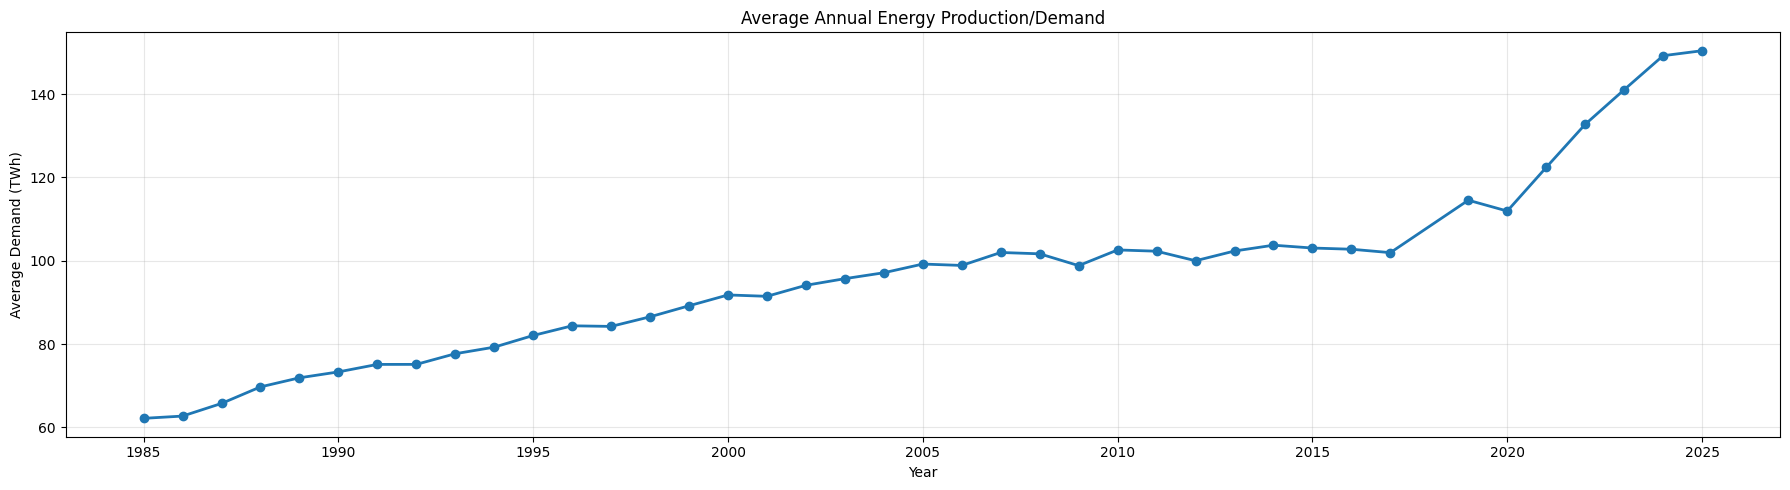

In [199]:

demand['Year'] = demand['Date'].dt.year
yearly_avg = demand.groupby('Year', as_index=False)['Demand (TWh)'].mean()
print(yearly_avg.head())

# Plot the yearly average
plt.rcParams["figure.figsize"] = (18, 5)
plt.plot(yearly_avg['Year'], yearly_avg['Demand (TWh)'], marker='o', linewidth=2, color='tab:blue')

plt.title('Average Annual Energy Production/Demand')
plt.xlabel('Year')
plt.ylabel('Average Demand (TWh)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


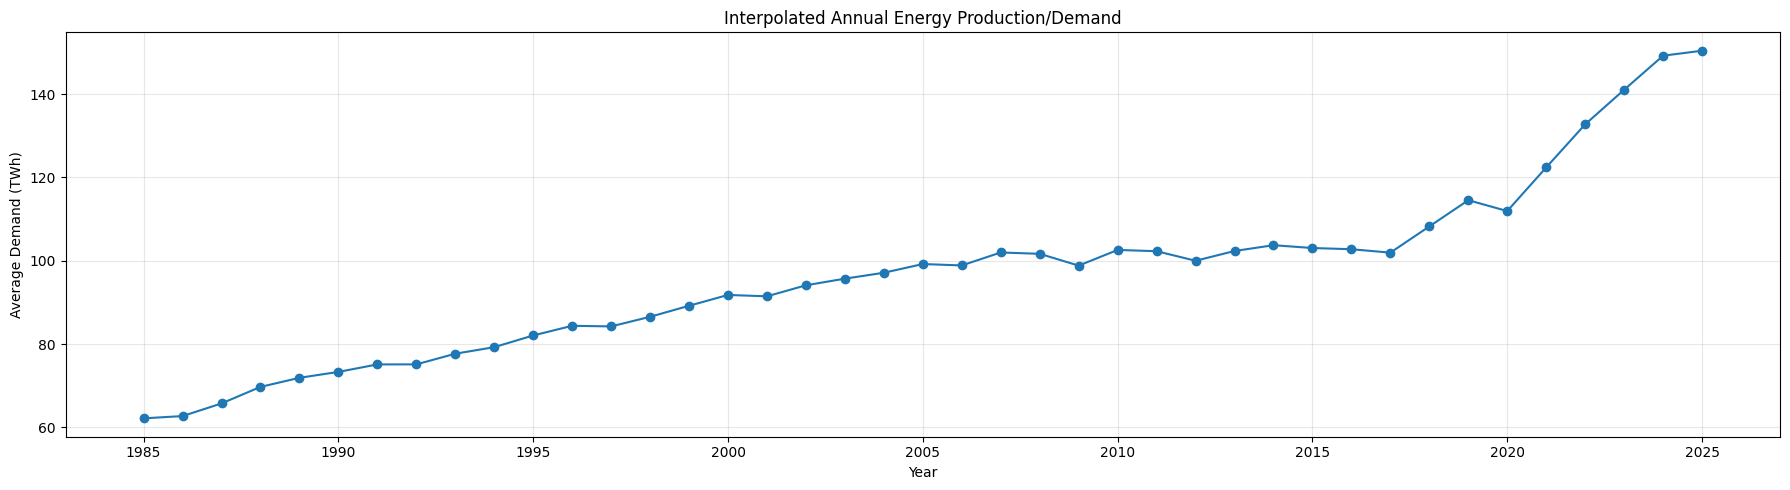

In [200]:
# Fill missing years by interpolation
all_years = pd.DataFrame({'Year': range(yearly_avg['Year'].min(), yearly_avg['Year'].max() + 1)})
yearly_avg = pd.merge(all_years, yearly_avg, on='Year', how='left')
yearly_avg['Demand (TWh)'] = yearly_avg['Demand (TWh)'].interpolate()

plt.figure(figsize=(18,5))
plt.plot(yearly_avg['Year'], yearly_avg['Demand (TWh)'], marker='o', color='tab:blue')
plt.title('Interpolated Annual Energy Production/Demand')
plt.xlabel('Year')
plt.ylabel('Average Demand (TWh)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


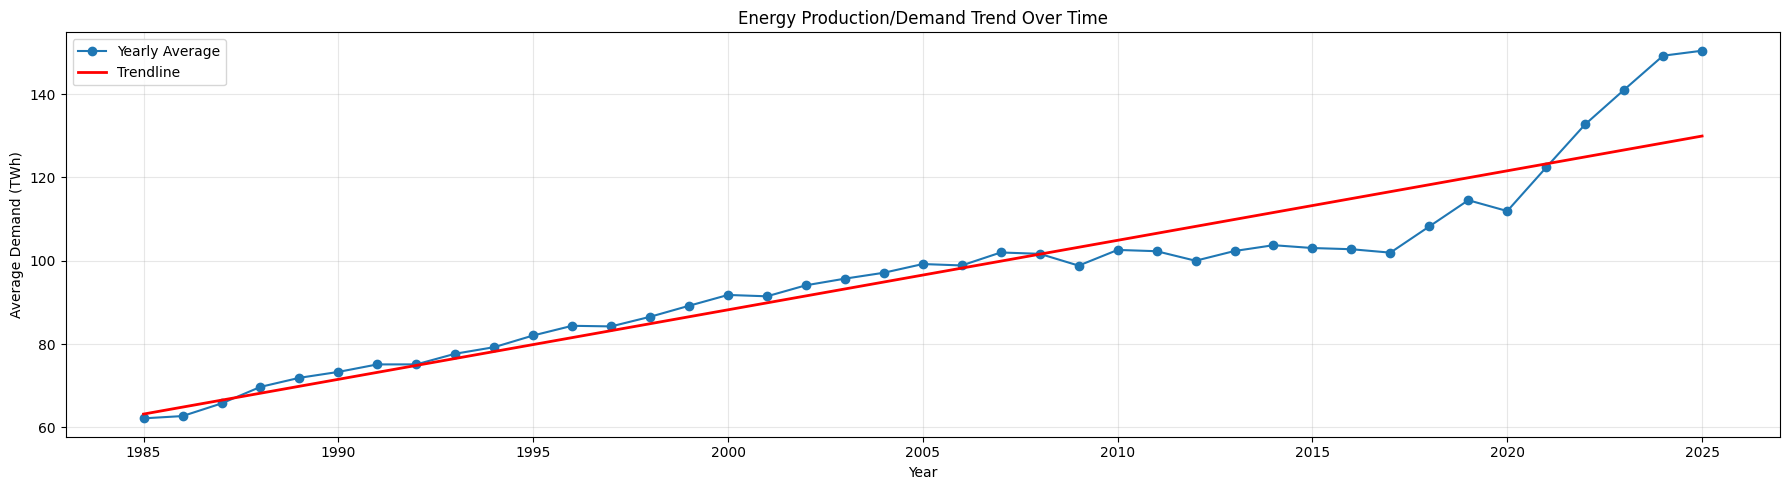

In [201]:
z = np.polyfit(yearly_avg['Year'], yearly_avg['Demand (TWh)'], 1)
p = np.poly1d(z)

plt.figure(figsize=(18,5))
plt.plot(yearly_avg['Year'], yearly_avg['Demand (TWh)'], marker='o', label='Yearly Average')
plt.plot(yearly_avg['Year'], p(yearly_avg['Year']), color='red', label='Trendline', linewidth=2)
plt.title('Energy Production/Demand Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Average Demand (TWh)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [202]:
demand.describe()

,Date,Demand (TWh),Year
count,472,472.000000,472.000000
mean,2004-05-31 12:42:42.711864448,95.354620,2004.330508
min,1985-01-01 00:00:00,55.315100,1985.000000
25%,1994-01-10 18:00:00,79.736950,1994.000000
50%,2004-01-08 12:00:00,92.767650,2004.000000
75%,2014-01-06 06:00:00,108.180200,2014.000000
max,2025-04-01 00:00:00,165.830000,2025.000000
std,NaN,21.654553,11.605735


In [203]:
# Multiplicative Decomposition
result_mul = seasonal_decompose(demand['Demand (TWh)'], model='multiplicative', period=12)
# Additive Decomposition
result_add = seasonal_decompose(demand['Demand (TWh)'], model='additive', period=12)

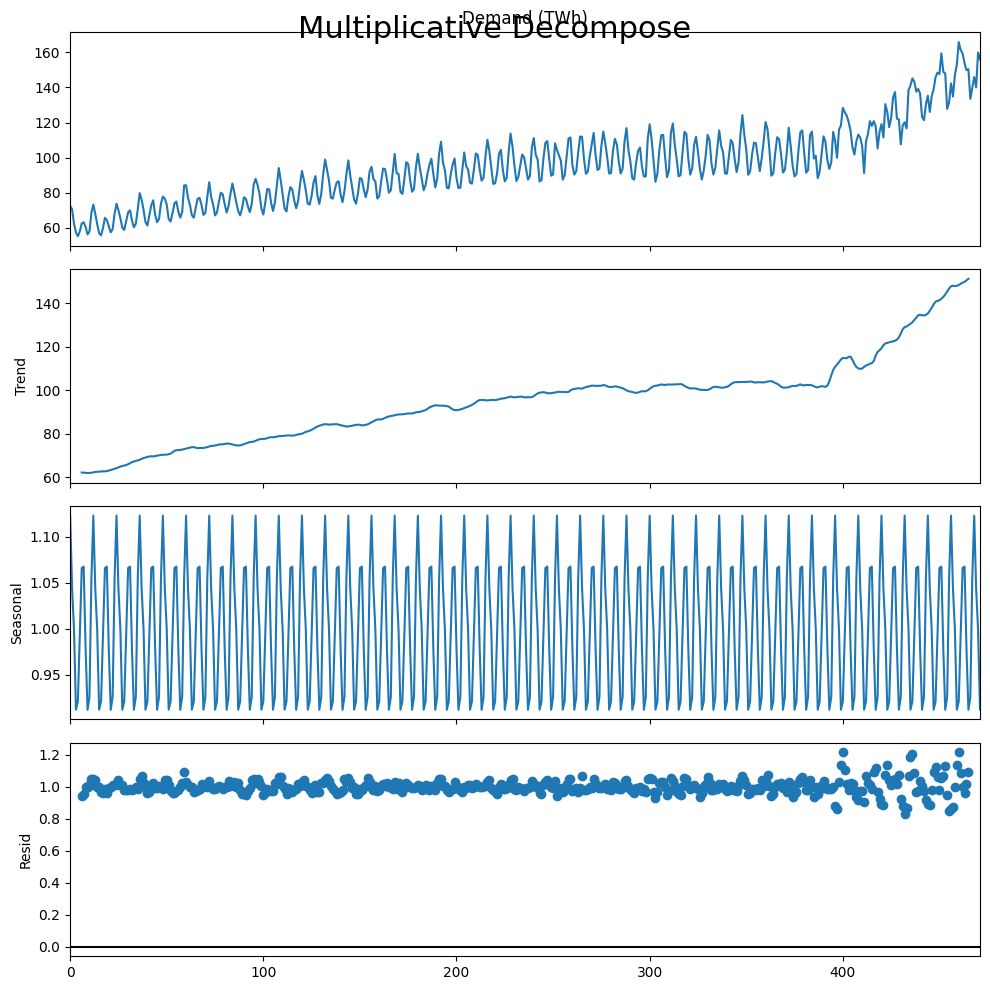

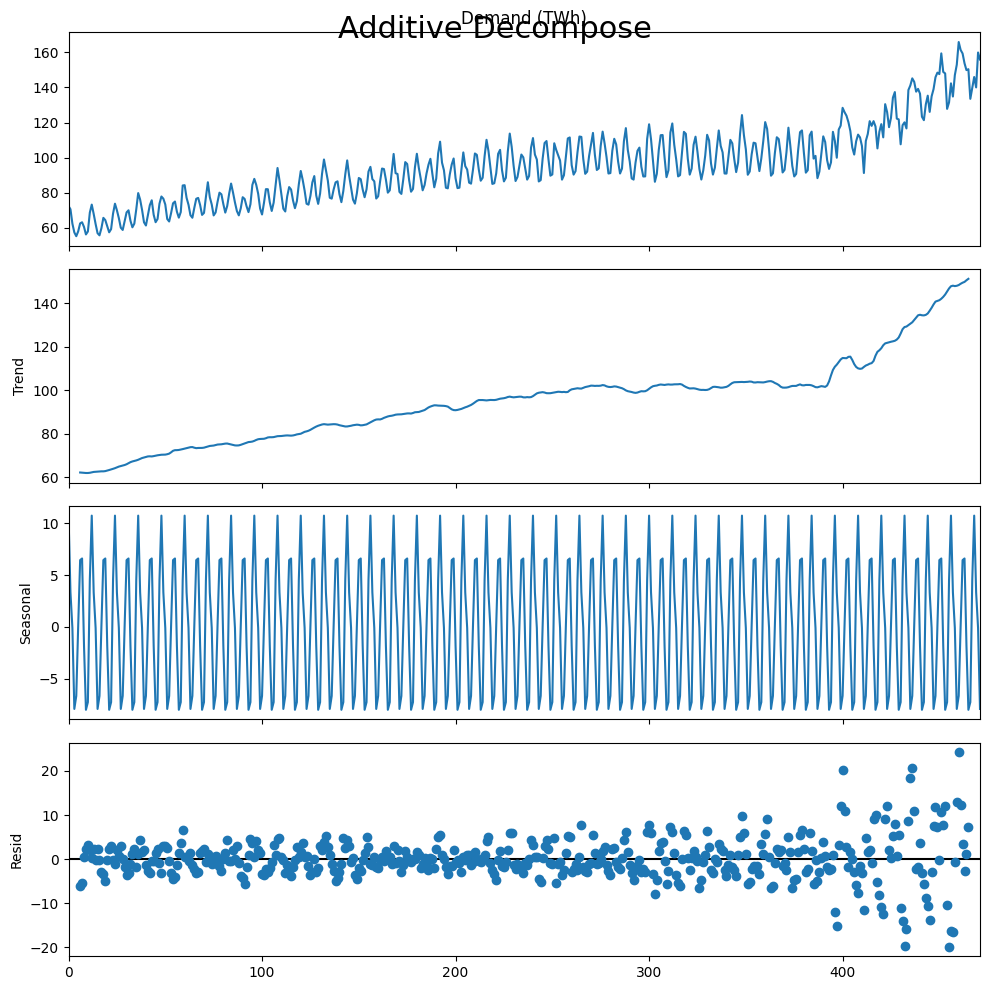

In [204]:
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)

result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [205]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(demand['Demand (TWh)'], order=(1, 1, 1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Demand (TWh)   No. Observations:                  472
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1267.408
Date:                            Mon, 03 Nov 2025   AIC                           2544.816
Time:                                    18:26:28   BIC                           2565.461
Sample:                                         0   HQIC                          2552.946
                                            - 472                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5875      0.029     20.039      0.000       0.530       0.645
ma.L1         -0.9334      0.018    -51.885      0.000      -0.969      -0.898
ar.S.L12      -0.0629      0.042     -1.490      0.136      -0.146       0.020
ma.S.L12      -0.5496      0.043    -12.739      0.000      -0.634      -0.465
sigma2        14.4411      0.524     27.568      0.000      13.414      15.468
===================================================================================
Ljung-Box (L1) (Q):                   4.92   Jarque-Bera (JB):               662.93
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):              10.23   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [206]:
prediction = []
last_date = pd.to_datetime(demand['Date']).iloc[-1]
future_dates = pd.date_range(start=last_date , periods=12, freq='MS')


for i in range(12):
    yhat = model_fit.predict(len(demand) + i-1)
    predicted_date = future_dates[i]
    predicted_value = yhat.iloc[0]
    prediction.append([predicted_date, predicted_value])

for a in prediction:
  print(a[0],a[1])


2025-04-01 00:00:00 160.47689999839926
2025-05-01 00:00:00 164.29581450910223
2025-06-01 00:00:00 164.154332417635
2025-07-01 00:00:00 164.01754724759388
2025-08-01 00:00:00 165.45048737361364
2025-09-01 00:00:00 159.08643464081442
2025-10-01 00:00:00 156.44824415706037
2025-11-01 00:00:00 142.3155982812051
2025-12-01 00:00:00 149.14104098149045
2026-01-01 00:00:00 155.78506721146562
2026-02-01 00:00:00 149.02352179920805
2026-03-01 00:00:00 164.12491463555497


In [207]:
#yhat.index[0]
print(prediction)

[[Timestamp('2025-04-01 00:00:00'), np.float64(160.47689999839926)], [Timestamp('2025-05-01 00:00:00'), np.float64(164.29581450910223)], [Timestamp('2025-06-01 00:00:00'), np.float64(164.154332417635)], [Timestamp('2025-07-01 00:00:00'), np.float64(164.01754724759388)], [Timestamp('2025-08-01 00:00:00'), np.float64(165.45048737361364)], [Timestamp('2025-09-01 00:00:00'), np.float64(159.08643464081442)], [Timestamp('2025-10-01 00:00:00'), np.float64(156.44824415706037)], [Timestamp('2025-11-01 00:00:00'), np.float64(142.3155982812051)], [Timestamp('2025-12-01 00:00:00'), np.float64(149.14104098149045)], [Timestamp('2026-01-01 00:00:00'), np.float64(155.78506721146562)], [Timestamp('2026-02-01 00:00:00'), np.float64(149.02352179920805)], [Timestamp('2026-03-01 00:00:00'), np.float64(164.12491463555497)]]


In [208]:
df2 = pd.DataFrame(prediction, columns = ['Date', 'Demand (TWh)'])
display(df2)
df2['Date'].dtypes


,Date,Demand (TWh)
0,2025-04-01,160.476900
1,2025-05-01,164.295815
2,2025-06-01,164.154332
3,2025-07-01,164.017547
4,2025-08-01,165.450487
5,2025-09-01,159.086435
6,2025-10-01,156.448244
7,2025-11-01,142.315598
8,2025-12-01,149.141041
9,2026-01-01,155.785067


dtype('<M8[ns]')

In [209]:
print(demand.head())
print(df2.head())
result = pd.concat([demand,df2], ignore_index=True, axis = 0)
result

        Date  Demand (TWh)  Year
0 1985-01-01       72.5052  1985
1 1985-01-02       70.6720  1985
2 1985-01-03       62.4502  1985
3 1985-01-04       57.4714  1985
4 1985-01-05       55.3151  1985
        Date  Demand (TWh)
0 2025-04-01    160.476900
1 2025-05-01    164.295815
2 2025-06-01    164.154332
3 2025-07-01    164.017547
4 2025-08-01    165.450487


,Date,Demand (TWh),Year
0,1985-01-01,72.505200,1985.0
1,1985-01-02,70.672000,1985.0
2,1985-01-03,62.450200,1985.0
3,1985-01-04,57.471400,1985.0
4,1985-01-05,55.315100,1985.0
...,...,...,...
479,2025-11-01,142.315598,NaN
480,2025-12-01,149.141041,NaN
481,2026-01-01,155.785067,NaN
482,2026-02-01,149.023522,NaN


In [210]:
df_predicted = pd.DataFrame(data=result)
df_predicted

,Date,Demand (TWh),Year
0,1985-01-01,72.505200,1985.0
1,1985-01-02,70.672000,1985.0
2,1985-01-03,62.450200,1985.0
3,1985-01-04,57.471400,1985.0
4,1985-01-05,55.315100,1985.0
...,...,...,...
479,2025-11-01,142.315598,NaN
480,2025-12-01,149.141041,NaN
481,2026-01-01,155.785067,NaN
482,2026-02-01,149.023522,NaN


In [211]:
print(df2.columns)
print(demand.columns)
print(df_predicted.columns)
df_predicted


Index(['Date', 'Demand (TWh)'], dtype='object')
Index(['Date', 'Demand (TWh)', 'Year'], dtype='object')
Index(['Date', 'Demand (TWh)', 'Year'], dtype='object')


,Date,Demand (TWh),Year
0,1985-01-01,72.505200,1985.0
1,1985-01-02,70.672000,1985.0
2,1985-01-03,62.450200,1985.0
3,1985-01-04,57.471400,1985.0
4,1985-01-05,55.315100,1985.0
...,...,...,...
479,2025-11-01,142.315598,NaN
480,2025-12-01,149.141041,NaN
481,2026-01-01,155.785067,NaN
482,2026-02-01,149.023522,NaN


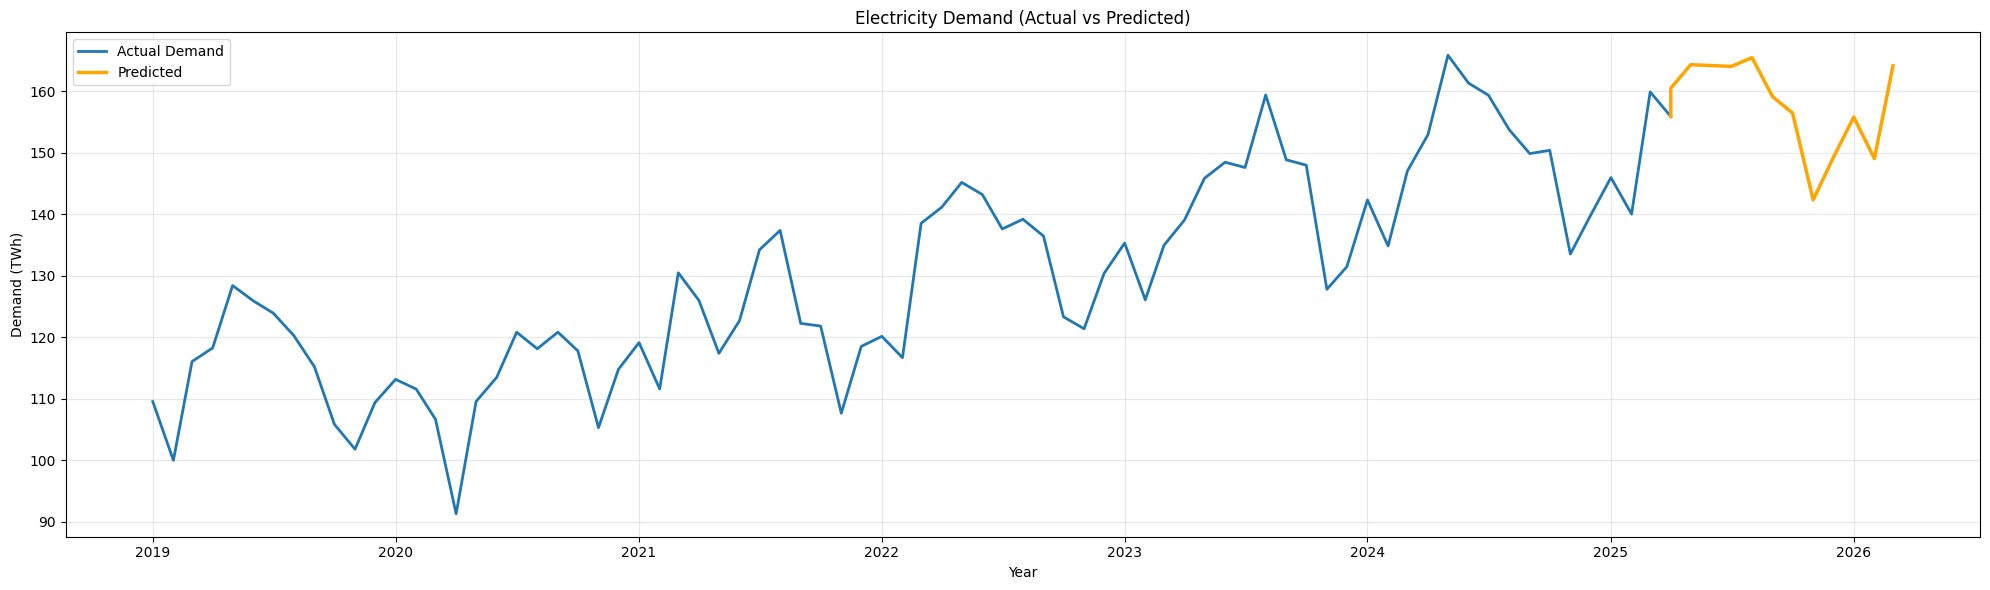

In [212]:
df_predicted['Date'] = pd.to_datetime(df_predicted['Date'])
demand_filtered = demand[demand['Year'] >= 2019]
df2_filtered = df_predicted[df_predicted['Date'] >= '2025-04-01']


plt.rcParams["figure.figsize"] = (20,6)

plt.plot(demand_filtered['Date'], demand_filtered['Demand (TWh)'],
         label="Actual Demand", color='tab:blue', linewidth=2)

plt.plot(df2_filtered['Date'], df2_filtered['Demand (TWh)'],
         label="Predicted", color='orange', linewidth=2.5)

plt.xlabel("Year")
plt.ylabel("Demand (TWh)")
plt.title("Electricity Demand (Actual vs Predicted)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
